In [1]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
from dateutil.relativedelta import *


In [2]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'Ready5'
runName='TestRun5'
region='himalayas'
size = 100000

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataset, region)
bbx = json.loads(bbx)
maxY=bbx['gridCellMaxY']
minT = datetime.datetime.utcfromtimestamp(bbx['minTime']) # divide by 1000 because it is in milliseconds
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-1600000,"gridCellMaxX":1400000,"gridCellMinY":-1000000,"gridCellMaxY":800000,"minTime":1279266673,"maxTime":1556338066,"totalPoints":2809617,"numberOfShards":258}


In [3]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,-35.162674,0.000000,-29.751991,-9.820787,-11.176451,-21.182444,-5.338712,-7.113104,106,127713
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,-19.614962,-7.946642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,81982
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,-7.506863,-23.118501,-22.218580,-10.585680,-29.813283,-28.030374,-4.983522,-57.700119,2003,191735
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,-8.233617,-13.118634,-7.109773,-10.878485,-12.928447,-5.411608,-15.874281,-12.089743,2053,85179
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,-14.209213,-15.771851,-23.351697,-17.716917,-24.619519,0.000000,-22.863138,8.903162,151,362312


In [4]:
# Add columns for filling in
newColumns = ['timeseries.dates', 'timeseries.averages', 'timeseries.change']
dfStats = dfStats.reindex(columns=np.append( dfStats.columns.values, newColumns))


In [5]:
# change type of two columns to object
dfStats[['timeseries.dates', 'timeseries.averages','timeseries.change']]= dfStats[['timeseries.dates','timeseries.averages','timeseries.change']].astype('object', inplace=True)
#dfStats.dtypes

In [6]:
for idx, line in dfStats.iterrows():
    if dfStats['statistics.afterGlacierMask'][idx] > 50:
        min_X,max_X=line['gridCell.minX'],line['gridCell.minX']+line['gridCell.size']
        min_Y,max_Y=line['gridCell.minY'],line['gridCell.minY']+line['gridCell.size']
        file = query.getNetCdfFile(parentDsName,dataset,region,min_X,max_X,min_Y,max_Y,minT,maxT)
        dfCell = MalardHelpers.getDataFrameFromNetCDF(file)
        # chuck away data before glacier year 2011
        #dfCell = dfCell[(dfCell.gla_year > 2010) & (dfCell.gla_year < 2019)]

        dateobjects = []
        for i, row in dfCell.iterrows():
            date = datetime.datetime.utcfromtimestamp(dfCell.time[i])
            dateobjects.append(date)
        
        dfCell['dateobject'] = dateobjects
        
        averages = []
        dates = []
        changes = []

        use_date = datetime.datetime(2010,11,1,0,0)
        while use_date <= datetime.datetime(2019,1,1,0,0):
            df_filt = dfCell[(dfCell.dateobject >= use_date) & (dfCell.dateobject <(use_date+relativedelta(months=+3)))]
            averages.append(df_filt.refDifference.mean())
            dates.append(use_date)
            use_date = use_date+relativedelta(months=+3)
        
        for i in averages:
            changes.append(i-averages[0])
        
        dfStats.at[idx,'timeseries.dates'] = dates
        dfStats.at[idx,'timeseries.averages'] = averages
        dfStats.at[idx,'timeseries.change'] = changes
        del dfCell
        query.releaseCache(file)

In [42]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsWithinDebrisMask,statistics.result_avgX,statistics.result_avgY,...,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered,statistics.tdx_filtered,timeseries.dates,timeseries.averages
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,67,-1.536373e+06,-21292.235597,...,-9.820787,-11.176451,-21.182444,-5.338712,-7.113104,106,NaN,127816.0,"[2010-11-01 00:00:00, 2011-02-01 00:00:00, 201...","[-15.573068500415332, nan, nan, -28.4195211863..."
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,0,-1.443186e+06,29895.766148,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,NaN,82086.0,NaN,NaN
2,-1500000,400000,100000,10.772159,107.072272,2003,-15.974319,305,-1.440702e+06,459939.024227,...,-10.585680,-29.813283,-28.030374,-4.983522,-57.700119,2003,NaN,191837.0,"[2010-11-01 00:00:00, 2011-02-01 00:00:00, 201...","[-40.62734616290008, nan, -23.658935894982566,..."
3,-1400000,0,100000,23.879357,63.412965,2053,-10.438546,1346,-1.339945e+06,57970.013154,...,-10.878485,-12.928447,-5.411608,-15.874281,-12.089743,2053,NaN,85282.0,"[2010-11-01 00:00:00, 2011-02-01 00:00:00, 201...","[-23.53932293433297, nan, -2.5417598203184606,..."
4,-1400000,100000,100000,2.365825,11.978117,151,-17.005372,92,-1.337447e+06,131513.591615,...,-17.716917,-24.619519,0.000000,-22.863138,8.903162,151,NaN,362414.0,"[2010-11-01 00:00:00, 2011-02-01 00:00:00, 201...","[-47.52341763628907, nan, nan, 12.184431136783..."


<IPython.core.display.Javascript object>


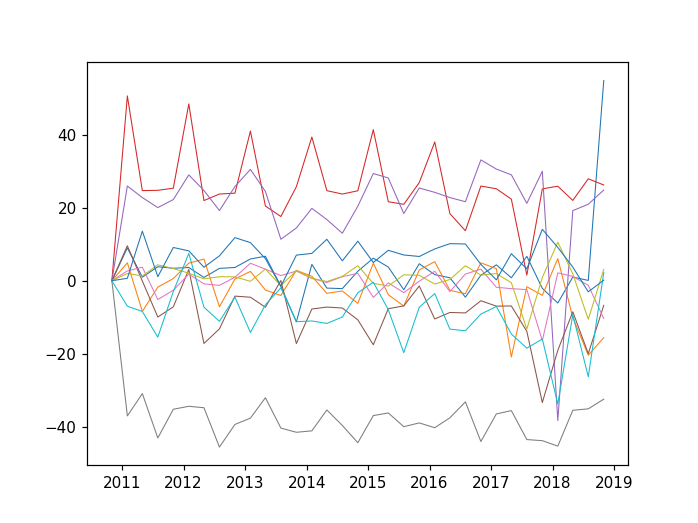

/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [7]:
count = 0
for idx, line in dfStats.iterrows():
    if line['statistics.afterGlacierMask'] > 5000:
        plt.plot(line['timeseries.dates'] , line['timeseries.change'], linewidth=0.7)
        count=count+1
        if count >10:
            break
        

In [8]:
dfStats.to_json("timeseries_results/timeseries_tdx2_run_per_3m.json")